In [8]:
from nilearn import plotting
from nilearn.image import resample_img, mean_img
from nilearn import datasets
import nibabel as nib

atlas_folder = "/home/harryzhang/Desktop/test_registration"
data_test_folder = '/media/harryzhang/VolumeWD/NIFTI_Renamed_test'

subject_list = ['540335','540410','540449','570255','570364']


/usr/local/lib/python3.6/dist-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


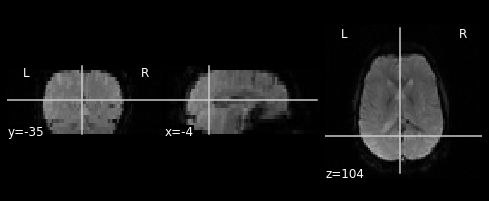

In [28]:
dwi = data_test_folder+'/540335/PWI.nii.gz'
img = nib.load(dwi)
plotting.plot_anat(img.slicer[:,:,:,1])